In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity, mean_squared_error

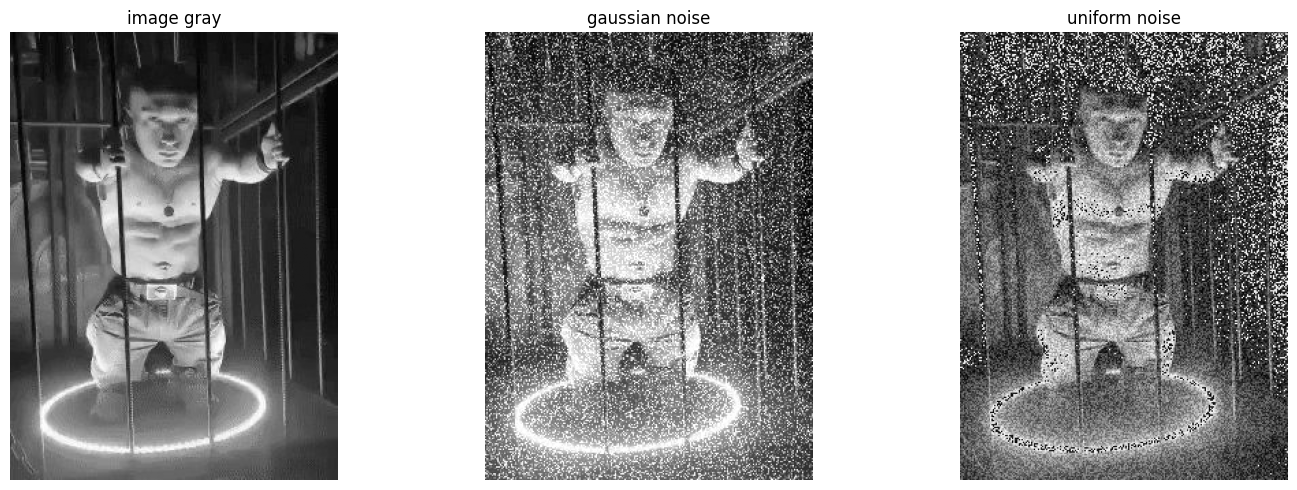

In [2]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

mean = 0
stddev = 100
noise_gauss = np.zeros(image_gray.shape, np.uint8)
cv2.randn(noise_gauss, mean, stddev)
noise_gauss_image = cv2.add(image_gray, noise_gauss)

low = -50
high = 50
noise_uniform = np.random.uniform(low, high, image_gray.shape).astype(np.uint8)
noise_uniform_image = np.clip(image_gray.astype(np.uint8) + noise_uniform, 0, 255).astype(np.uint8)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(image_gray, cmap='gray'); plt.title('image gray'); plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(noise_gauss_image, cmap='gray'); plt.title('gaussian noise'); plt.axis('off')
plt.subplot(1, 3, 3); plt.imshow(noise_uniform_image, cmap='gray'); plt.title('uniform noise'); plt.axis('off')
plt.tight_layout()
plt.show()

-- Filters results: --
Gaussian 3x3 sigma=0: MSE=1737.14, SSIM=0.4355
Gaussian 5x5 sigma=0: MSE=1614.41, SSIM=0.4951
Gaussian 7x7 sigma=0: MSE=1586.69, SSIM=0.5343
Gaussian 3x3 sigma=1: MSE=1708.62, SSIM=0.4443
Gaussian 3x3 sigma=2: MSE=1695.57, SSIM=0.4445
Gaussian 5x5 sigma=1: MSE=1625.13, SSIM=0.4873
Gaussian 5x5 sigma=2: MSE=1601.89, SSIM=0.5170
Gaussian 7x7 sigma=1: MSE=1619.82, SSIM=0.4909
Gaussian 7x7 sigma=2: MSE=1609.49, SSIM=0.5372
Median 3x3: MSE=1005.99, SSIM=0.4171
Median 5x5: MSE=706.52, SSIM=0.5124
Median 7x7: MSE=748.60, SSIM=0.5134
Bilateral d=9 sigma=25: MSE=3399.20, SSIM=0.2294
Bilateral d=9 sigma=75: MSE=1685.14, SSIM=0.3679
Bilateral d=15 sigma=100: MSE=1534.64, SSIM=0.3851
NLM h=10: MSE=3823.80, SSIM=0.2190
NLM h=20: MSE=3786.36, SSIM=0.2329
NLM h=30: MSE=2630.43, SSIM=0.3235


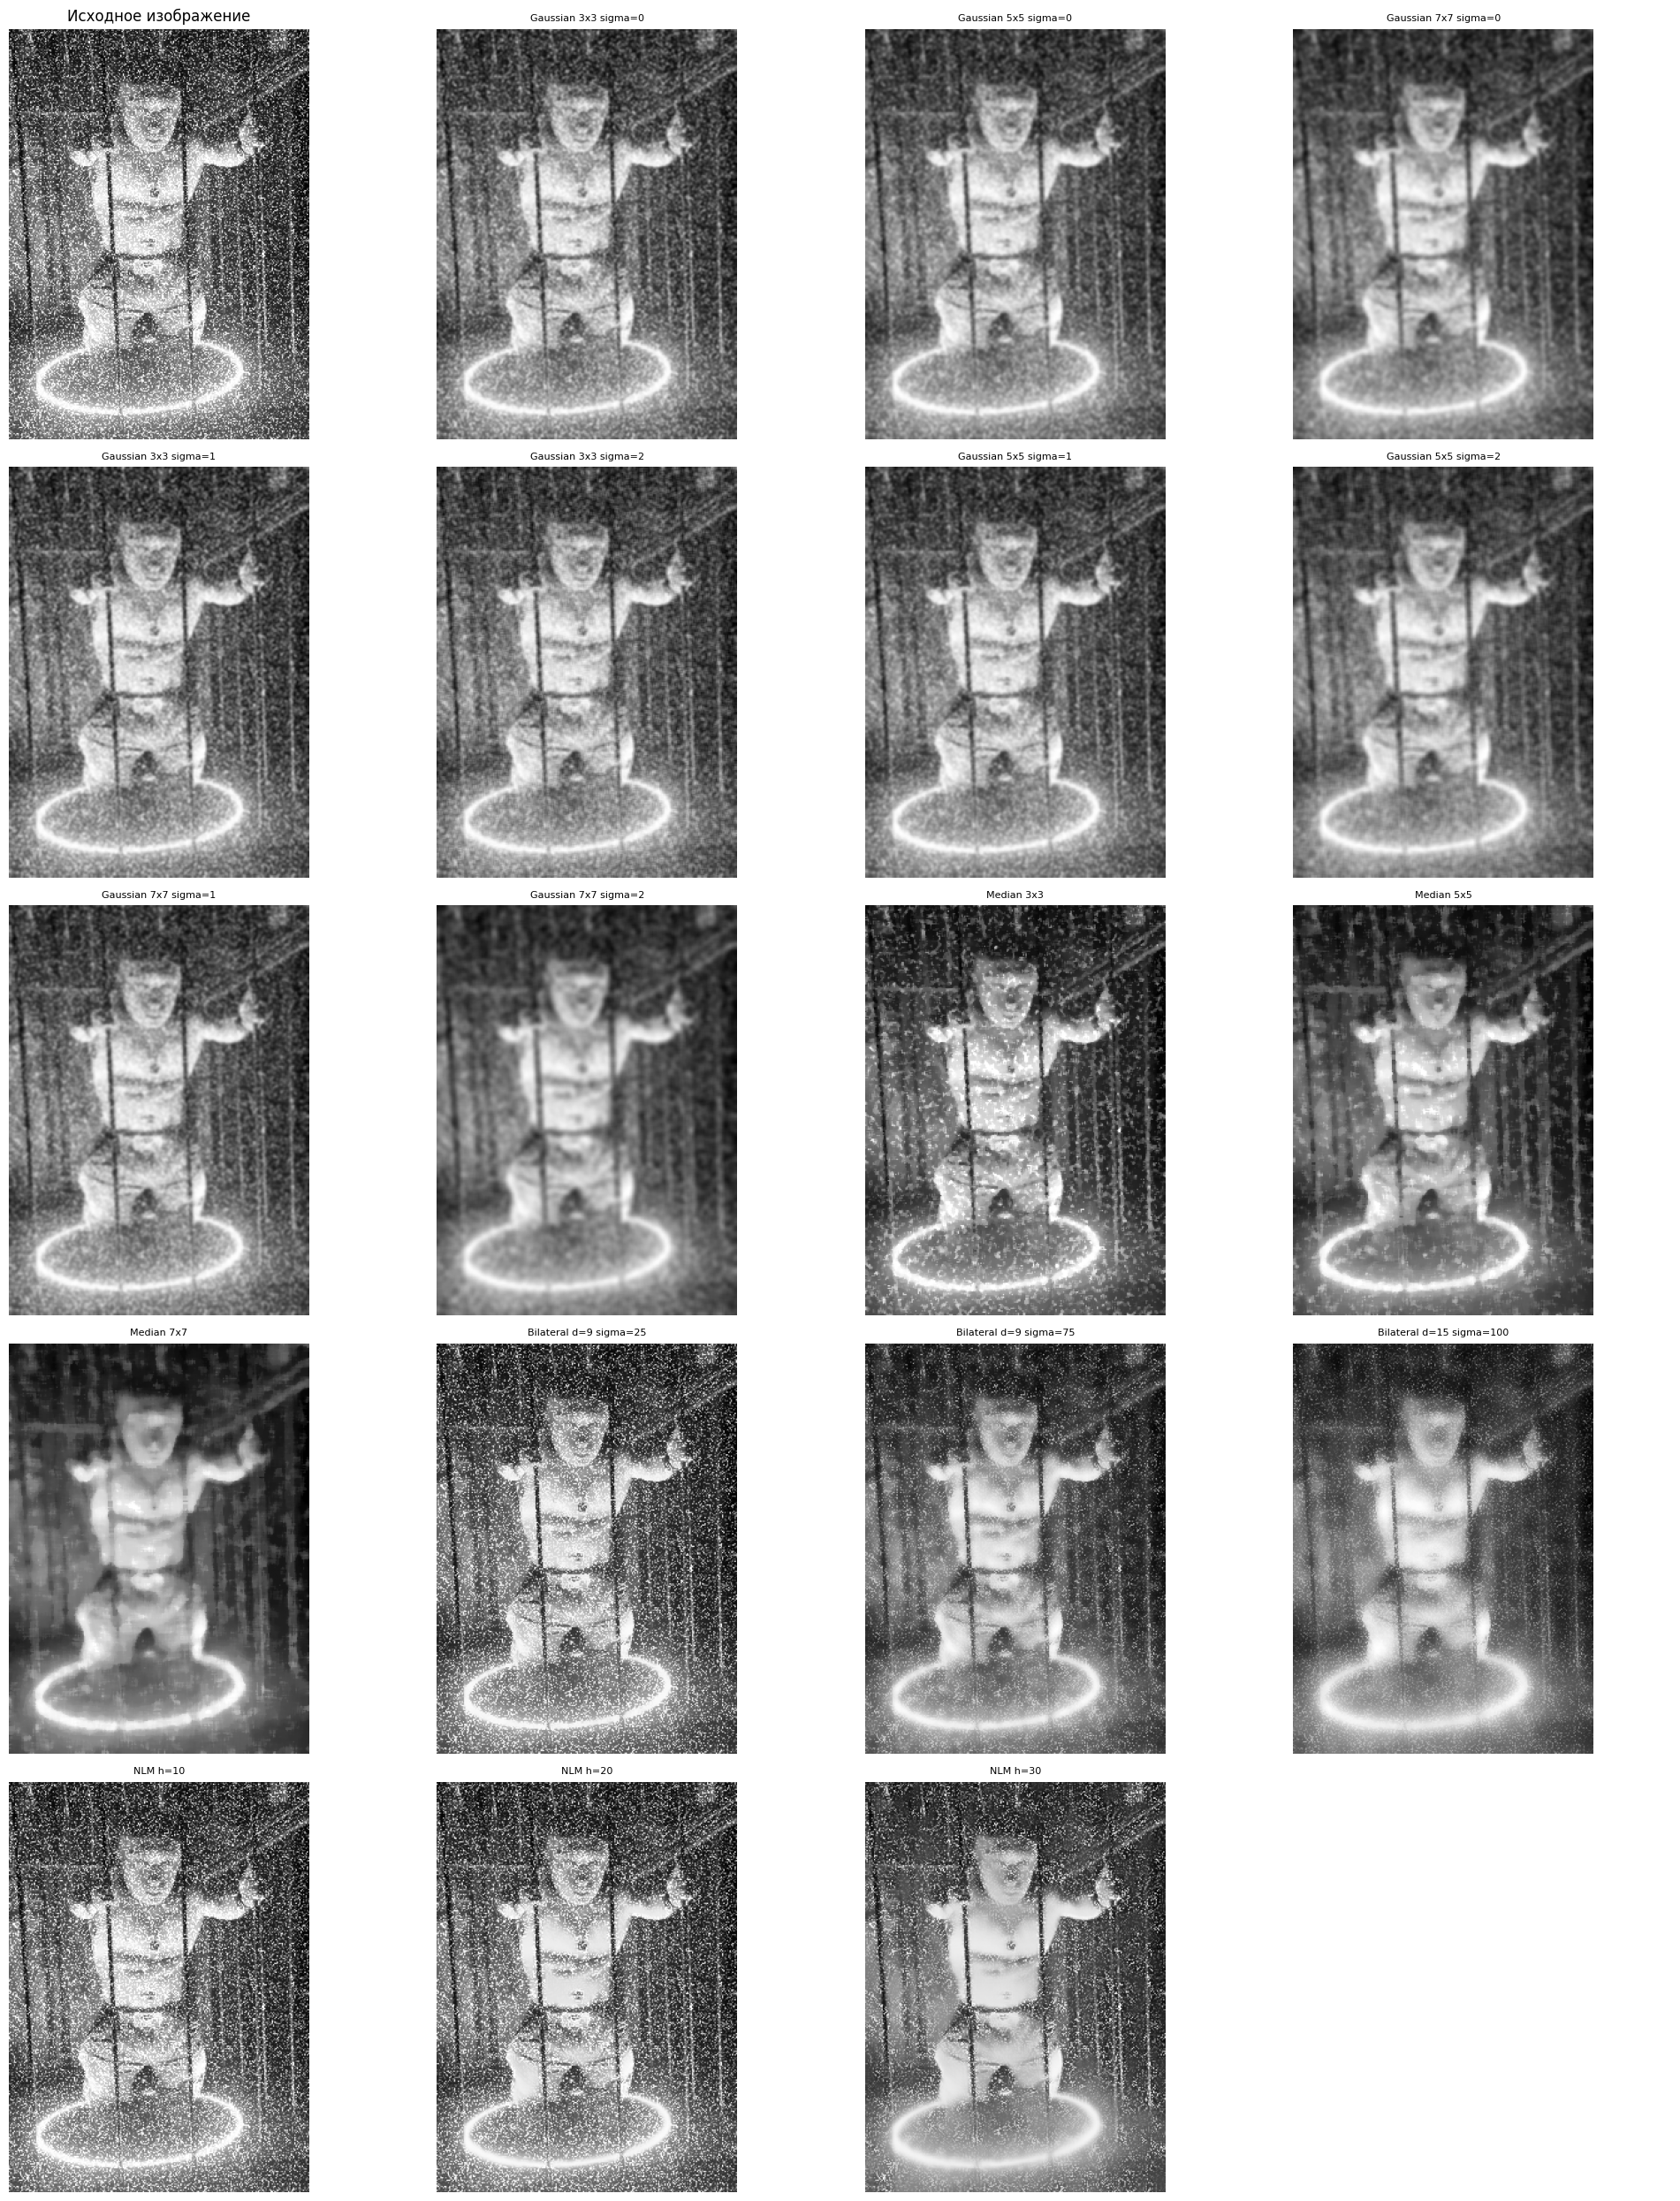

In [3]:
def filter_test(noisy_image, clean_image):
    filters_to_test = [
        ('Gaussian 3x3 sigma=0', cv2.GaussianBlur(noisy_image, (3, 3), 0)),
        ('Gaussian 5x5 sigma=0', cv2.GaussianBlur(noisy_image, (5, 5), 0)),
        ('Gaussian 7x7 sigma=0', cv2.GaussianBlur(noisy_image, (7, 7), 0)),
        ('Gaussian 3x3 sigma=1', cv2.GaussianBlur(noisy_image, (3, 3), 1)),
        ('Gaussian 3x3 sigma=2', cv2.GaussianBlur(noisy_image, (3, 3), 2)),
        ('Gaussian 5x5 sigma=1', cv2.GaussianBlur(noisy_image, (5, 5), 1)),
        ('Gaussian 5x5 sigma=2', cv2.GaussianBlur(noisy_image, (5, 5), 2)),
        ('Gaussian 7x7 sigma=1', cv2.GaussianBlur(noisy_image, (7, 7), 1)),
        ('Gaussian 7x7 sigma=2', cv2.GaussianBlur(noisy_image, (7, 7), 2)),
        
        ('Median 3x3', cv2.medianBlur(noisy_image, 3)),
        ('Median 5x5', cv2.medianBlur(noisy_image, 5)),
        ('Median 7x7', cv2.medianBlur(noisy_image, 7)),
        
        ('Bilateral d=9 sigma=25', cv2.bilateralFilter(noisy_image, 9, 25, 25)),
        ('Bilateral d=9 sigma=75', cv2.bilateralFilter(noisy_image, 9, 75, 75)),
        ('Bilateral d=15 sigma=100', cv2.bilateralFilter(noisy_image, 15, 100, 100)),
        
        ('NLM h=10', cv2.fastNlMeansDenoising(noisy_image, h=10)),
        ('NLM h=20', cv2.fastNlMeansDenoising(noisy_image, h=20)),
        ('NLM h=30', cv2.fastNlMeansDenoising(noisy_image, h=30))
    ]
    results = {}

    print("-- Filters results: --")
    
    for filter_name, filtered_image in filters_to_test:
        mse = mean_squared_error(clean_image, filtered_image)
        ssim = structural_similarity(clean_image, filtered_image)
        
        print(f"{filter_name}: MSE={mse:.2f}, SSIM={ssim:.4f}")
        
        results[filter_name] = {
            'image': filtered_image,
            'mse': mse,
            'ssim': ssim
        }
    return results

def visualize(noisy_image, results):
    n_filters = len(results)
    n_cols = 4
    n_rows = (n_filters + n_cols) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()
    
    axes[0].imshow(noisy_image, cmap='gray')
    axes[0].set_title('Исходное изображение')
    axes[0].axis('off')
    
    for idx, (filter_name, result) in enumerate(results.items(), 1):
        if idx < len(axes):
            axes[idx].imshow(result['image'], cmap='gray')
            axes[idx].set_title(f'{filter_name}', fontsize=8)
            axes[idx].axis('off')
    
    for idx in range(len(results) + 1, len(axes)):
        axes[idx].axis('off')
        
    plt.tight_layout()
    plt.show()

results = filter_test(noise_gauss_image, image_gray)
visualize(noise_gauss_image, results)

Лучший фильтр по MSE:
Название: Median 5x5
MSE: 706.52 (чем меньше, тем лучше)
SSIM: 0.5124

Лучший фильтр по SSIM:
Название: Gaussian 7x7 sigma=2
MSE: 1609.49
SSIM: 0.5372 (чем ближе к 1, тем лучше)


(np.float64(-0.5), np.float64(239.5), np.float64(327.5), np.float64(-0.5))

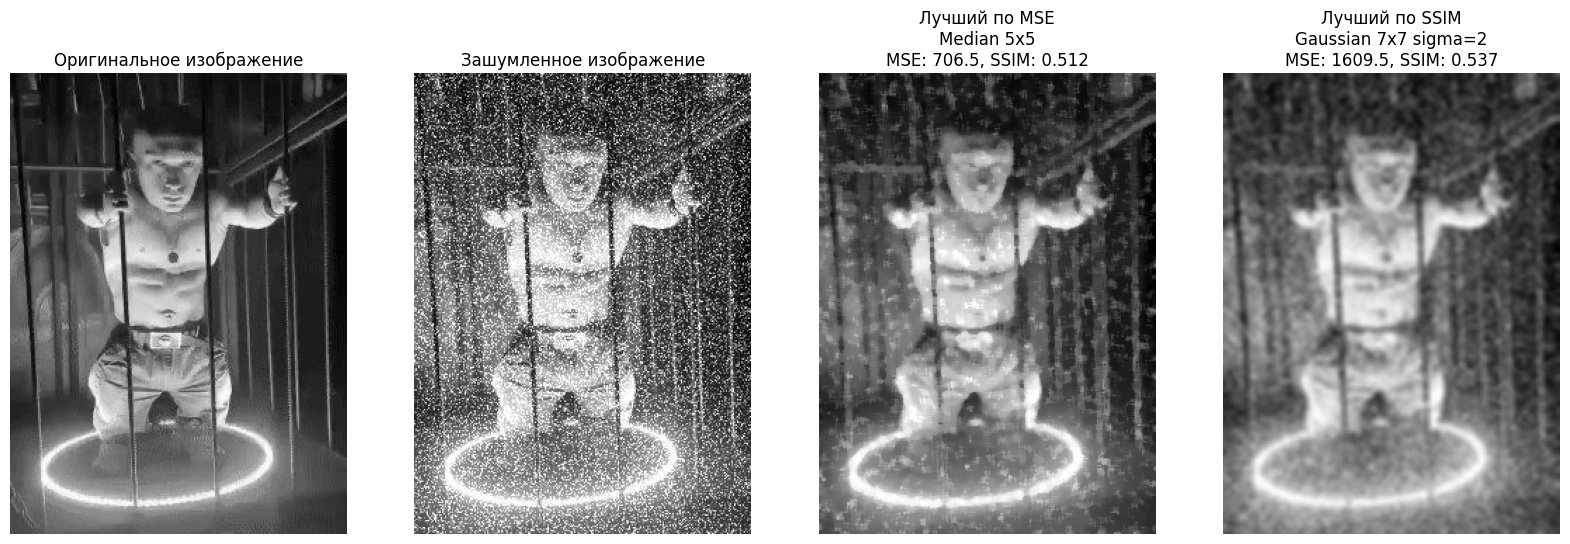

In [4]:
def find_best_filter_mse(clean_image, results):
    best_filter = None
    
    for filter_name, result in results.items():
        mse = result['mse']
        ssim = result['ssim']
        
        if best_filter is None or mse < best_filter['mse']:
            best_filter = {
                'name': filter_name,
                'image': result['image'],
                'mse': mse,
                'ssim': ssim
            }

        elif mse == best_filter['mse'] and ssim > best_filter['ssim']:
            best_filter = {
                'name': filter_name,
                'image': result['image'],
                'mse': mse,
                'ssim': ssim
            }
    
    return best_filter

def find_best_filter_ssim(clean_image, results):
    best_filter = None
    
    for filter_name, result in results.items():
        mse = result['mse']
        ssim = result['ssim']
        
        if best_filter is None or ssim > best_filter['ssim']:
            best_filter = {
                'name': filter_name,
                'image': result['image'],
                'mse': mse,
                'ssim': ssim
            }

        elif ssim == best_filter['ssim'] and mse < best_filter['mse']:
            best_filter = {
                'name': filter_name,
                'image': result['image'],
                'mse': mse,
                'ssim': ssim
            }
    
    return best_filter

best_mse = find_best_filter_mse(image_gray, results)
best_ssim = find_best_filter_ssim(image_gray, results)

print("Лучший фильтр по MSE:")
print(f"Название: {best_mse['name']}")
print(f"MSE: {best_mse['mse']:.2f} (чем меньше, тем лучше)")
print(f"SSIM: {best_mse['ssim']:.4f}")

print("\nЛучший фильтр по SSIM:")
print(f"Название: {best_ssim['name']}")
print(f"MSE: {best_ssim['mse']:.2f}")
print(f"SSIM: {best_ssim['ssim']:.4f} (чем ближе к 1, тем лучше)")

plt.figure(figsize=(20, 15))

plt.subplot(1, 4, 1)
plt.imshow(image_gray, cmap='gray')
plt.title('Оригинальное изображение')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(noise_gauss_image, cmap='gray')
plt.title('Зашумленное изображение')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(best_mse['image'], cmap='gray')
plt.title(f'Лучший по MSE\n{best_mse["name"]}\nMSE: {best_mse["mse"]:.1f}, SSIM: {best_mse["ssim"]:.3f}')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(best_ssim['image'], cmap='gray')
plt.title(f'Лучший по SSIM\n{best_ssim["name"]}\nMSE: {best_ssim["mse"]:.1f}, SSIM: {best_ssim["ssim"]:.3f}')
plt.axis('off')